In [68]:
# !pip install scikit-optimize
# from google.colab import drive
# drive.mount('/content/drive')

# Imports

In [32]:
import time
import timeit
import math

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import preprocessing

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import pearsonr, probplot, shapiro, kstest, norm, anderson, skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from scipy.stats import ttest_rel

# Functions

In [2]:
def boxplot_all_columns(data, title):
    plt.figure(figsize=(14, 7))
    plt.suptitle(f'Boxplots for {title}', fontsize=16)
    numeric_columns = data.select_dtypes(include=['number']).columns
    for i, column in enumerate(numeric_columns):
        plt.subplot(2, 4, i + 1)
        data.boxplot(column=[column])
        plt.title(column)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def histogram_all_columns(data, title):
    plt.figure(figsize=(14, 7))
    plt.suptitle(f'Histograms for {title}', fontsize=16)
    for i, column in enumerate(data.columns):
      plt.subplot(2,4,i+1)
      # plt.subplots_adjust(hspace=0.5, wspace=0.5)
      sns.histplot(data[column], kde=True)
      plt.title(column)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def qq_all_columns(data, title):
    plt.figure(figsize=(14, 7))
    plt.suptitle(f'Q-Q plots for {title}', fontsize=16)
    for i, column in enumerate(data.columns):
      plt.subplot(2,4,i+1)
      probplot(data[column], dist="norm", plot=plt)
      plt.title(column)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def normality_all_columns(data):
    results = []
    for column in data.columns:
      stat_s, p_s = shapiro(data[column])
      stat_ks, p_ks = kstest(data[column], 'norm', args=(data[column].mean(), data[column].std()))
      skewness = skew(data[column])
      kurt = kurtosis(data[column])
      results.append({'Feature': column,
                      'Shapiro statistic': round(stat_s,3), 'Shapiro p-value': round(p_s,3),
                      'KS statistic': round(stat_ks,3), 'KS p-value': round(p_ks,3),
                      'Skew': round(skewness,3), 'Kurtosis': round(kurt,3)})
    results_df = pd.DataFrame(results)
    return results_df

def correlate(data, type):
    corr_p = data.corr(method=type)
    display(corr_p)
    plot_corr(corr_p)

def plot_corr(corr):
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.color_palette("Spectral", as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True)

def calculate_vif(variables):
    vif_data = pd.DataFrame()
    vif_data["features"] = variables.columns
    vif_data["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
    return vif_data

def ols(dataset, xs, pred, title):
    print(title)
    print()
    y = dataset['Price']
    x1 = dataset[xs]
    x = sm.add_constant(x1)
    model_ols = sm.OLS(y,x).fit()
    p = sm.add_constant(pred, has_constant='add')
    predictions = model_ols.predict(p)
    print(f'Prediction: £{int(predictions[0])}')
    print()
    return model_ols.summary()

# Data

In [9]:
# Note: Data are asking prices on Auto Trader; these are not necessarily the price they sell for

# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/car_data.csv')
data = pd.read_csv('data/car_data.csv')

In [4]:
display(data.head())
print()
display(data.describe(include='all'))
print()
print('Unique values')
display(data.nunique().sort_values())
print()
print('Null values')
display(data.isnull().sum().sort_values())

,Price,Year,Generation,Trim,Mileage,Distance,Seller
0,5995,2017,7,ST-3,102857,7,Private
1,11995,2017,7,ST-3,30100,21,Trade
2,14295,2019,8,ST-3,42150,26,Trade
3,10800,2017,7,ST-3,46000,29,Trade
4,21495,2022,8,ST-3,10000,29,Trade


,Price,Year,Generation,Trim,Mileage,Distance,Seller
count,635.000000,635.000000,635.000000,635,635.000000,635.000000,635
unique,NaN,NaN,NaN,2,NaN,NaN,2
top,NaN,NaN,NaN,ST-3,NaN,NaN,Trade
freq,NaN,NaN,NaN,364,NaN,NaN,497
mean,11913.724409,2016.223622,7.464567,NaN,47636.426772,175.433071,NaN
std,5391.029049,36.549181,0.499136,NaN,27875.479021,71.853842,NaN
min,3030.000000,1100.000000,7.000000,NaN,9.000000,7.000000,NaN
25%,7487.500000,2015.000000,7.000000,NaN,23339.000000,135.000000,NaN
50%,10000.000000,2017.000000,7.000000,NaN,47000.000000,174.000000,NaN
75%,15992.500000,2020.000000,8.000000,NaN,67664.000000,208.000000,NaN



Unique values


Trim            2
Generation      2
Seller          2
Year           14
Distance      222
Price         400
Mileage       507
dtype: int64


Null values


Price         0
Year          0
Generation    0
Trim          0
Mileage       0
Distance      0
Seller        0
dtype: int64

In [10]:
# Generation: 7 to 1, 8 to 0 (i.e. mine is 1)
# Trim: ST-3 to 1, ST-2 to 0 (i.e. mine is 1)
# Seller: Private to 1, trade to 0 (i.e. mine is 1)

data['Generation'] = data['Generation'].map({7:1, 8:0})
data['Trim'] = data['Trim'].map({'ST-3':1, 'ST-2':0})
data['Seller'] = data['Seller'].map({'Private':1, 'Trade':0})
# data.rename(columns={'Seller':'Seller'}, inplace=True)

data.describe(include='all')

,Price,Year,Generation,Trim,Mileage,Distance,Seller
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,11913.724409,2016.223622,0.535433,0.573228,47636.426772,175.433071,0.217323
std,5391.029049,36.549181,0.499136,0.494998,27875.479021,71.853842,0.412749
min,3030.000000,1100.000000,0.000000,0.000000,9.000000,7.000000,0.000000
25%,7487.500000,2015.000000,0.000000,0.000000,23339.000000,135.000000,0.000000
50%,10000.000000,2017.000000,1.000000,1.000000,47000.000000,174.000000,0.000000
75%,15992.500000,2020.000000,1.000000,1.000000,67664.000000,208.000000,0.000000
max,26950.000000,2025.000000,1.000000,1.000000,164530.000000,462.000000,1.000000


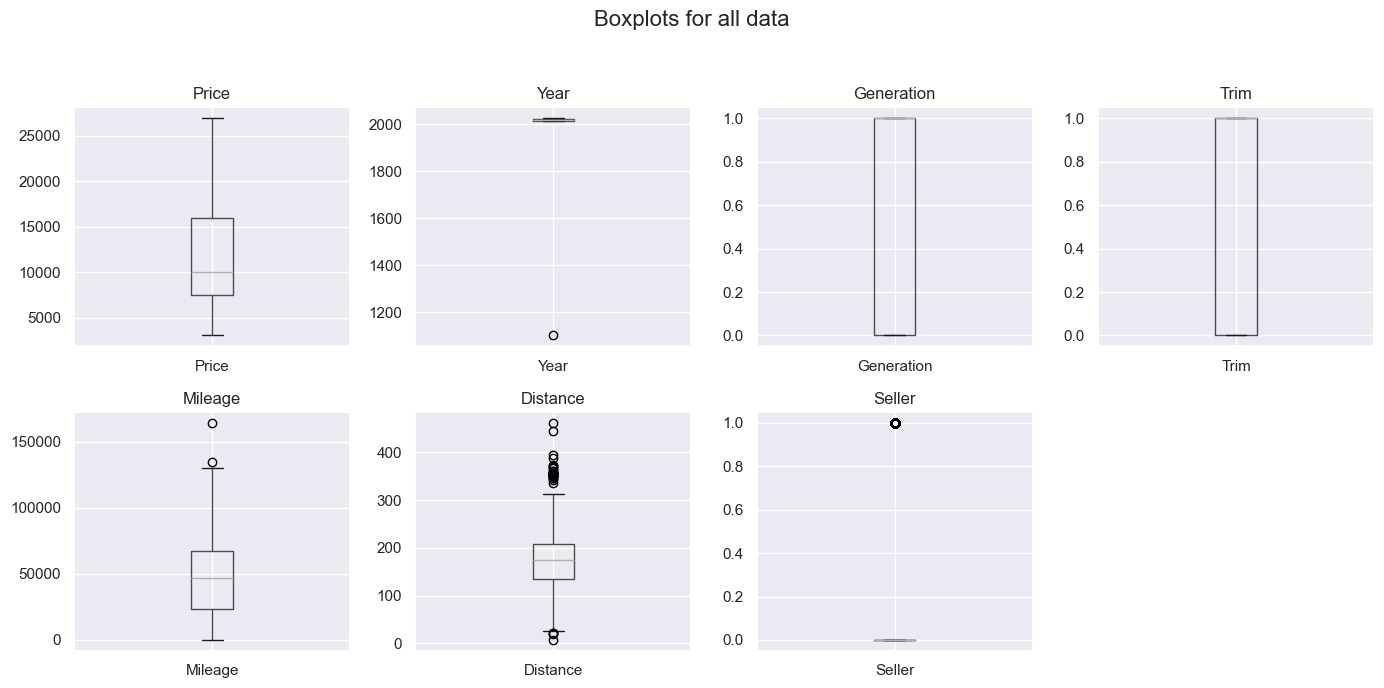

In [6]:
boxplot_all_columns(data, 'all data')

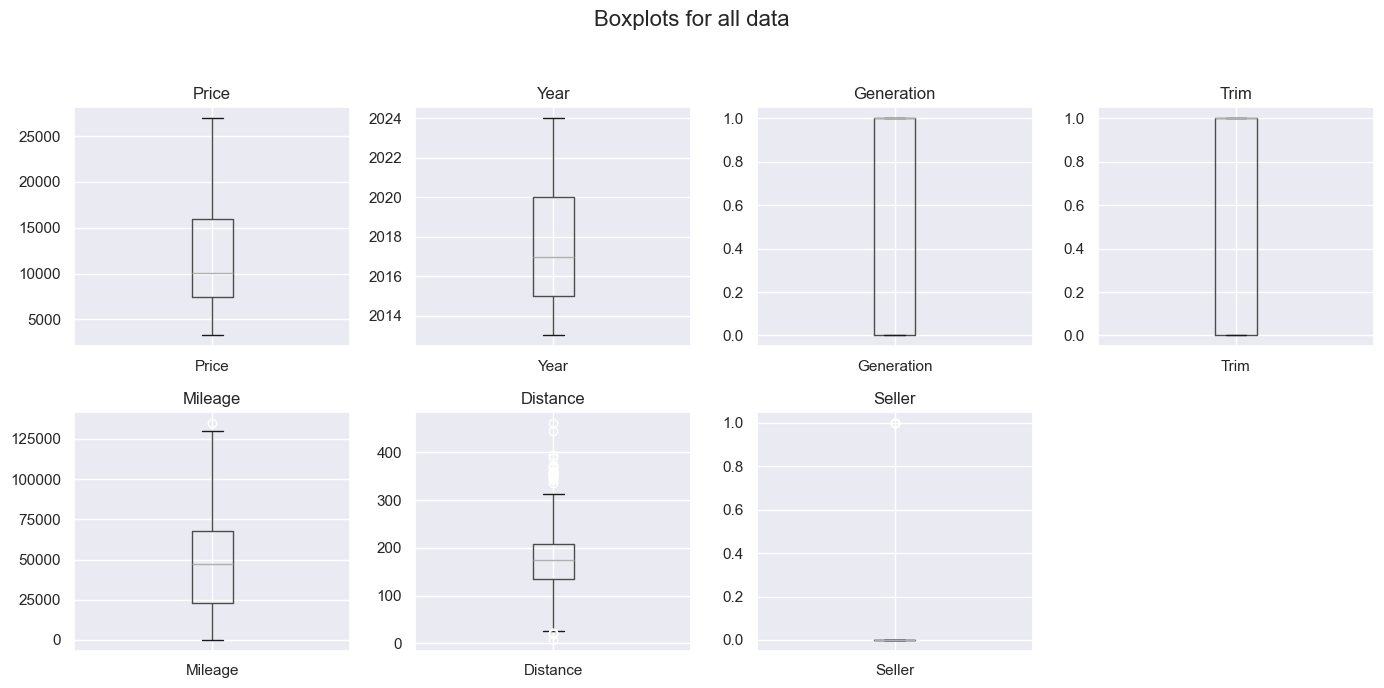

In [11]:
# Fixed outlier values come from manually checking raw data

data[data['Year']==1100]
data.loc[17, 'Year'] = 2020

data[data['Year']==2025]
data.loc[80, 'Year'] = 2016
data.loc[110, 'Year'] = 2019

data['Mileage'].sort_values().tail()
data.drop(index=53, inplace=True)

boxplot_all_columns(data, 'all data')

## Data splitting

In [13]:
# Data split by categories (generation, trim, seller type)

gen7_data = data[data['Generation'] == 1]

gen7_st3_data = gen7_data[gen7_data['Trim'] == 1]
gen7_st2_data = gen7_data[gen7_data['Trim'] == 0]

gen7_private_data = gen7_data[gen7_data['Seller'] == 1]
gen7_trade_data = gen7_data[gen7_data['Seller'] == 0]

gen7_st3_private_data = gen7_st3_data[gen7_st3_data['Seller'] == 1]
gen7_st3_trade_data = gen7_st3_data[gen7_st3_data['Seller'] == 0]

gen7_st2_private_data = gen7_st2_data[gen7_st2_data['Seller'] == 1]
gen7_st2_trade_data = gen7_st2_data[gen7_st2_data['Seller'] == 0]

gen8_data = data[data['Generation'] == 0]

gen8_st3_data = gen8_data[gen8_data['Trim'] == 1]
gen8_st2_data = gen8_data[gen8_data['Trim'] == 0]

gen8_private_data = gen8_data[gen8_data['Seller'] == 1]
gen8_trade_data = gen8_data[gen8_data['Seller'] == 0]

gen8_st3_private_data = gen8_st3_data[gen8_st3_data['Seller'] == 1]
gen8_st3_trade_data = gen8_st3_data[gen8_st3_data['Seller'] == 0]

gen8_st2_private_data = gen8_st2_data[gen8_st2_data['Seller'] == 1]
gen8_st2_trade_data = gen8_st2_data[gen8_st2_data['Seller'] == 0]

# gen7_st3_private_data_dropped = gen7_st3_private_data.drop(['Generation', 'Trim', 'Seller'], axis=1) # these are effectively equivalent
gen7_st3_private_data_dropped = gen7_st3_private_data.loc[:, gen7_st3_private_data.nunique() != 1]

st3_data = data[data['Trim'] == 1]
st3_data_dropped = st3_data.loc[:, st3_data.nunique() != 1]


In [47]:
mine_all = pd.DataFrame({
    'Year': [2017],
    'Generation': [1],
    'Trim': [1],
    'Mileage': [38000],
    'Distance': [1],
    'Seller': [1]
})

mine_simple = pd.DataFrame({
    'Year': [2017],
    'Mileage': [38000],
    'Distance': [1]
})

In [10]:
# X and y values for later

X = data.drop(['Price'], axis=1).copy()
y = data['Price'].copy()

# Exploratory data analysis

## Price graphs

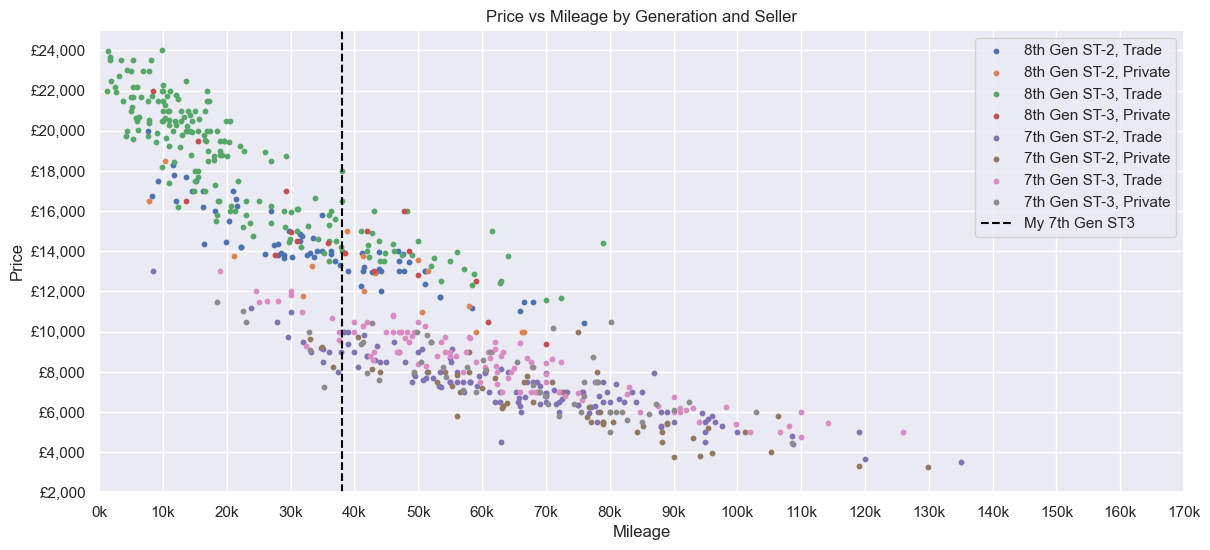

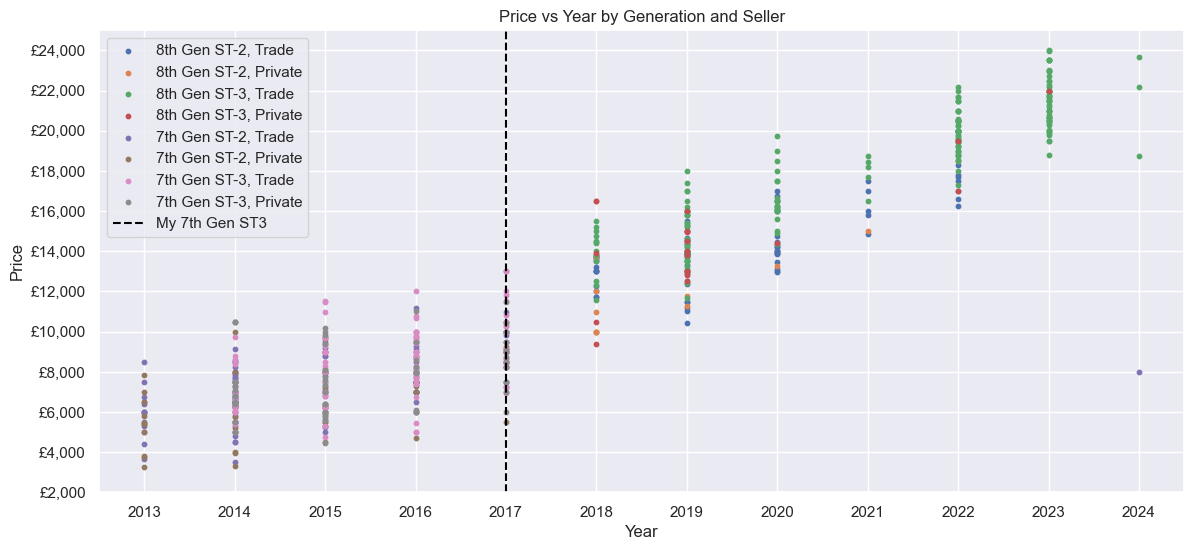

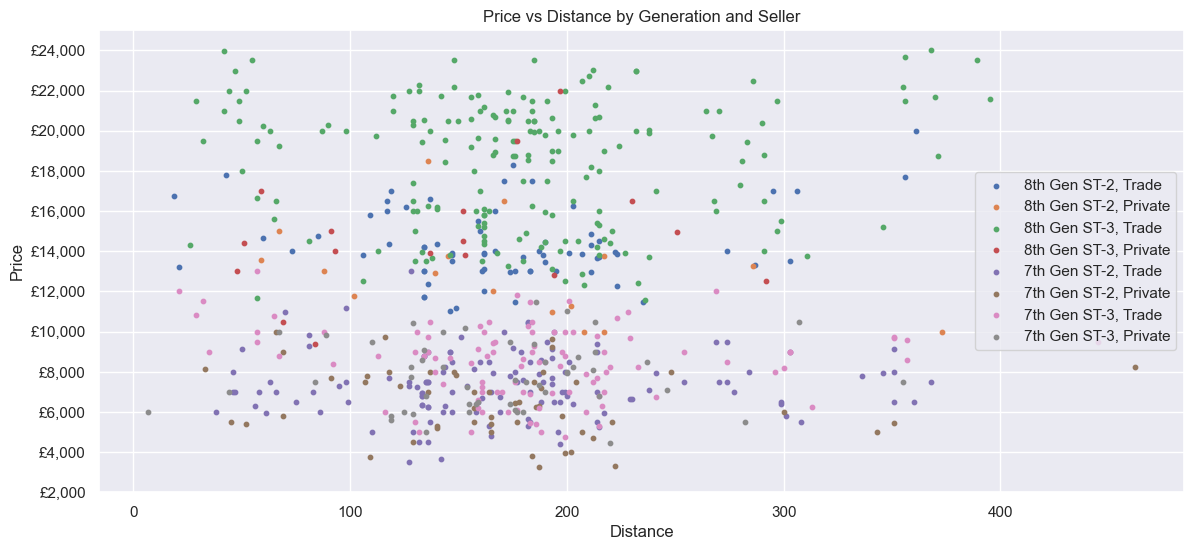

In [11]:
def plot_price_vs(x_col):
    plt.figure(figsize=(14, 6))
    plt.title(f'Price vs {x_col} by Generation and Seller')

    y_gen7_st2_private = gen7_st2_private_data['Price']
    y_gen7_st2_trade = gen7_st2_trade_data['Price']
    x_gen7_st2_private = gen7_st2_private_data[x_col]
    x_gen7_st2_trade = gen7_st2_trade_data[x_col]

    y_gen7_st3_private = gen7_st3_private_data['Price']
    y_gen7_st3_trade = gen7_st3_trade_data['Price']
    x_gen7_st3_private = gen7_st3_private_data[x_col]
    x_gen7_st3_trade = gen7_st3_trade_data[x_col]

    y_gen8_st2_private = gen8_st2_private_data['Price']
    y_gen8_st2_trade = gen8_st2_trade_data['Price']
    x_gen8_st2_private = gen8_st2_private_data[x_col]
    x_gen8_st2_trade = gen8_st2_trade_data[x_col]

    y_gen8_st3_private = gen8_st3_private_data['Price']
    y_gen8_st3_trade = gen8_st3_trade_data['Price']
    x_gen8_st3_private = gen8_st3_private_data[x_col]
    x_gen8_st3_trade = gen8_st3_trade_data[x_col]

    plt.scatter(x_gen8_st2_trade, y_gen8_st2_trade, s=10, label='8th Gen ST-2, Trade')
    plt.scatter(x_gen8_st2_private, y_gen8_st2_private, s=10, label='8th Gen ST-2, Private')

    plt.scatter(x_gen8_st3_trade, y_gen8_st3_trade, s=10, label='8th Gen ST-3, Trade')
    plt.scatter(x_gen8_st3_private, y_gen8_st3_private, s=10, label='8th Gen ST-3, Private')

    plt.scatter(x_gen7_st2_trade, y_gen7_st2_trade, s=10, label='7th Gen ST-2, Trade')
    plt.scatter(x_gen7_st2_private, y_gen7_st2_private, s=10, label='7th Gen ST-2, Private')

    plt.scatter(x_gen7_st3_trade, y_gen7_st3_trade, s=10, label='7th Gen ST-3, Trade')
    plt.scatter(x_gen7_st3_private, y_gen7_st3_private, s=10, label='7th Gen ST-3, Private')

    if x_col == 'Mileage':
        plt.axvline(38000, color='black', linestyle='--', label='My 7th Gen ST3')
    elif x_col == 'Year':
        plt.axvline(2017, color='black', linestyle='--', label='My 7th Gen ST3')

    ax = plt.gca()

    plt.ylabel('Price')
    plt.ylim(2000,25000)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2000))
    def currency_formatter(y, pos):
        return '£{:,.0f}'.format(y)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

    plt.xlabel(f'{x_col}')
    if x_col == 'Mileage':
      plt.xlim(0,170000)
      ax.xaxis.set_major_locator(ticker.MultipleLocator(10000))
      def thousands_formatter(x, pos):
          return '{:.0f}k'.format(x / 1000)
      ax.xaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
    elif x_col == 'Year':
      plt.xlim(2012.5, 2024.5)
      ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.grid(True)
    plt.legend()
    plt.show()

plot_price_vs('Mileage')
plot_price_vs('Year')
plot_price_vs('Distance')

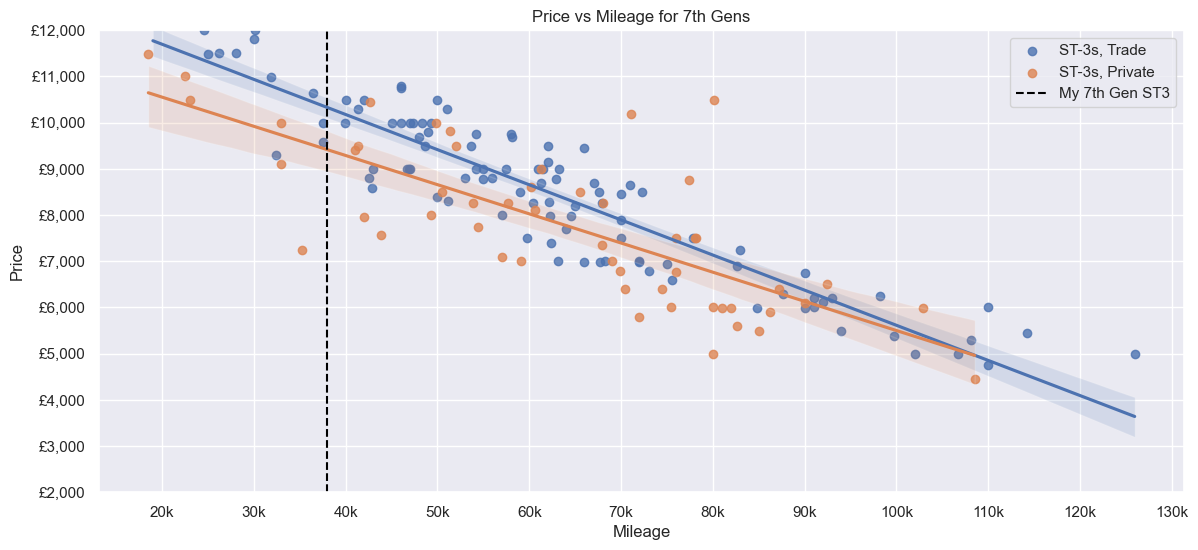

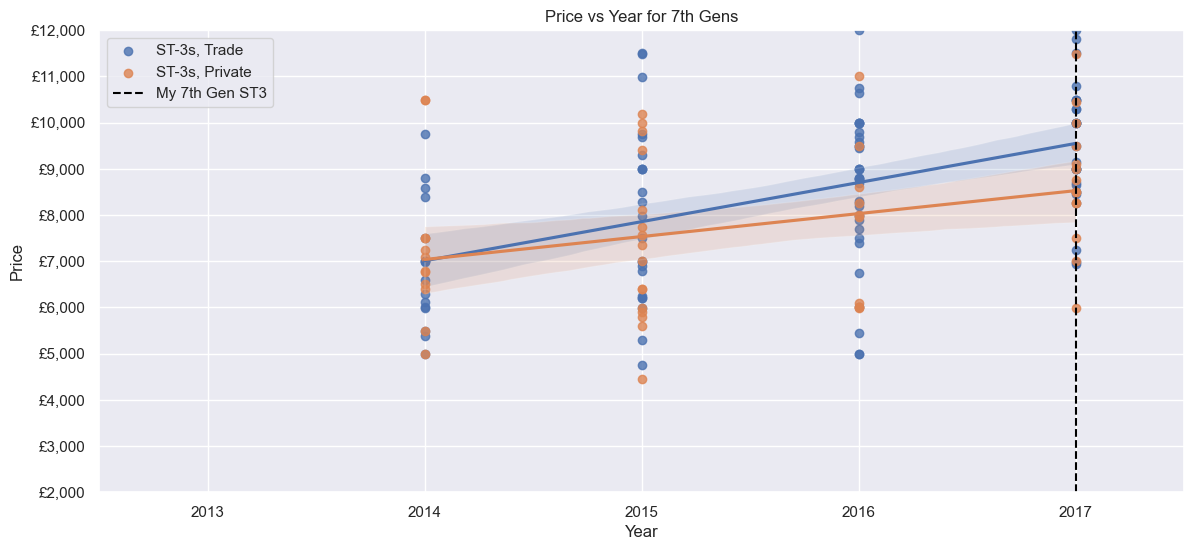

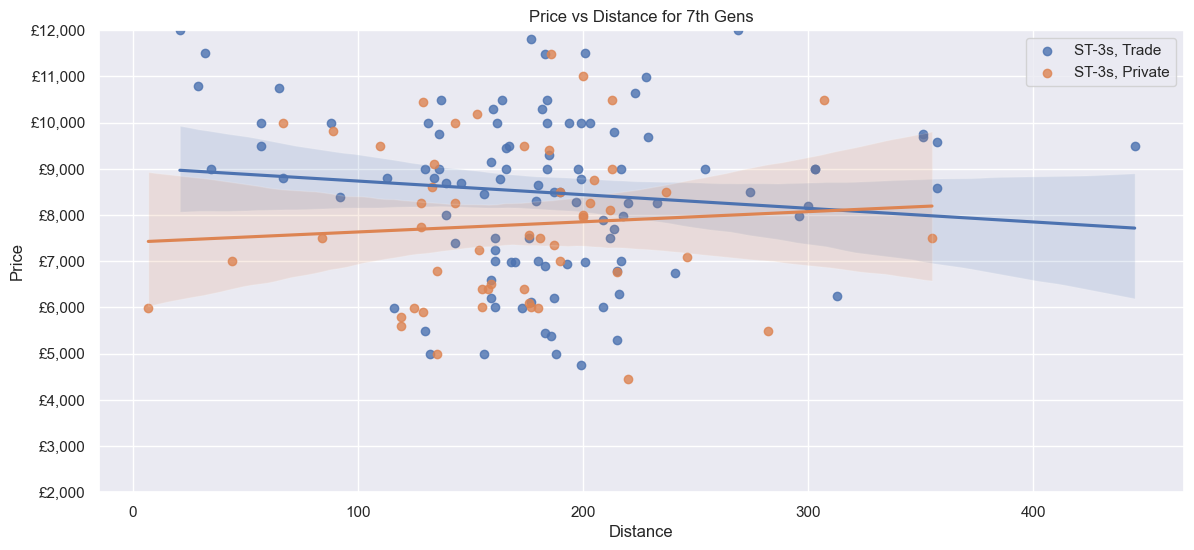

In [63]:
def plot_price_vs_gen7(x_col):
  plt.figure(figsize=(14, 6))
  plt.title(f'Price vs {x_col} for 7th Gens')

  # ax = sns.regplot(data=gen7_st2_trade_data, x=x_col, y='Price', label='ST-2s, Trade')
  # ax = sns.regplot(data=gen7_private_data, x=x_col, y='Price', label='Privates', scatter_kws={'s': 1})
  # ax = sns.regplot(data=gen7_st2_private_data, x=x_col, y='Price', label='ST-2s, Private')
  ax = sns.regplot(data=gen7_st3_trade_data, x=x_col, y='Price', label='ST-3s, Trade')
  ax = sns.regplot(data=gen7_st3_private_data, x=x_col, y='Price', label='ST-3s, Private')

  if x_col == 'Mileage':
      plt.axvline(38000, color='black', linestyle='--', label='My 7th Gen ST3')
  elif x_col == 'Year':
      plt.axvline(2017, color='black', linestyle='--', label='My 7th Gen ST3')

  plt.ylabel('Price')
  plt.ylim(2000, 12000)
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
  def currency_formatter(y, pos):
      return '£{:,.0f}'.format(y)
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

  plt.xlabel(f'{x_col}')
  if x_col == 'Mileage':
    # plt.xlim(10000, 170000)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10000))
    def thousands_formatter(x, pos):
        return '{:.0f}k'.format(x / 1000)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
  elif x_col == 'Year':
    plt.xlim(2012.5, 2017.5)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.grid(True)
  plt.legend()
  plt.show()

plot_price_vs_gen7('Mileage')
plot_price_vs_gen7('Year')
plot_price_vs_gen7('Distance')

## Histograms

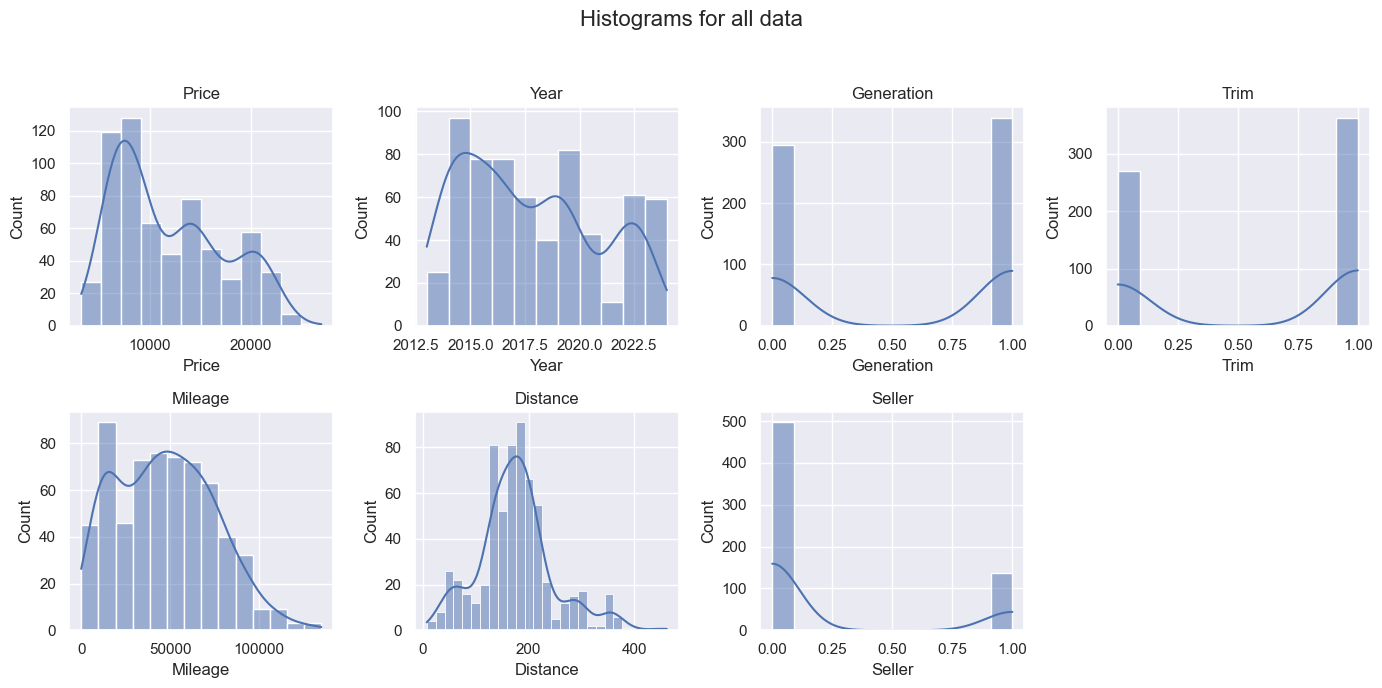

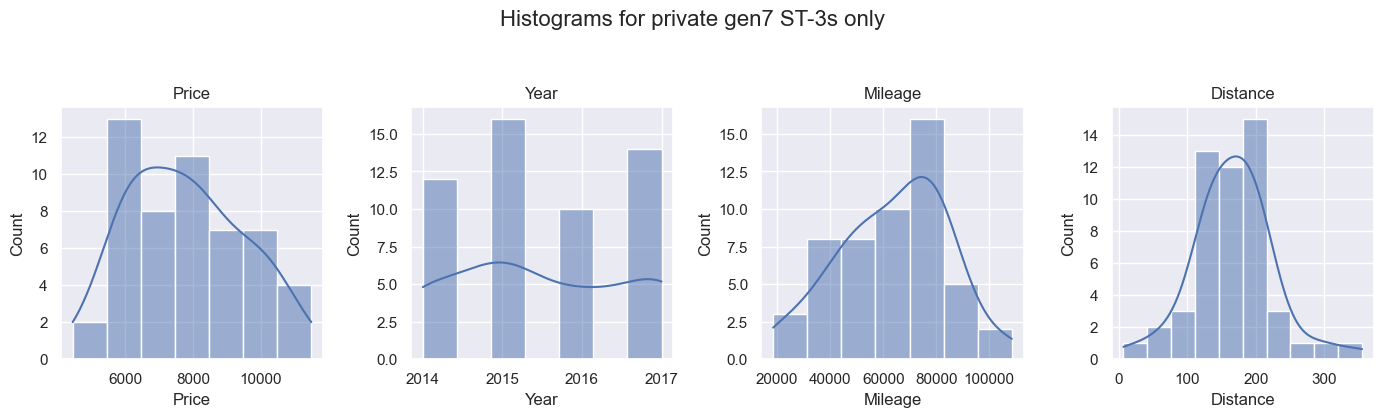

In [64]:
histogram_all_columns(data, 'all data')
# histogram_all_columns(gen7_data, 'gen7 only')
histogram_all_columns(gen7_st3_private_data_dropped, 'private gen7 ST-3s only')

## Q-Q plots

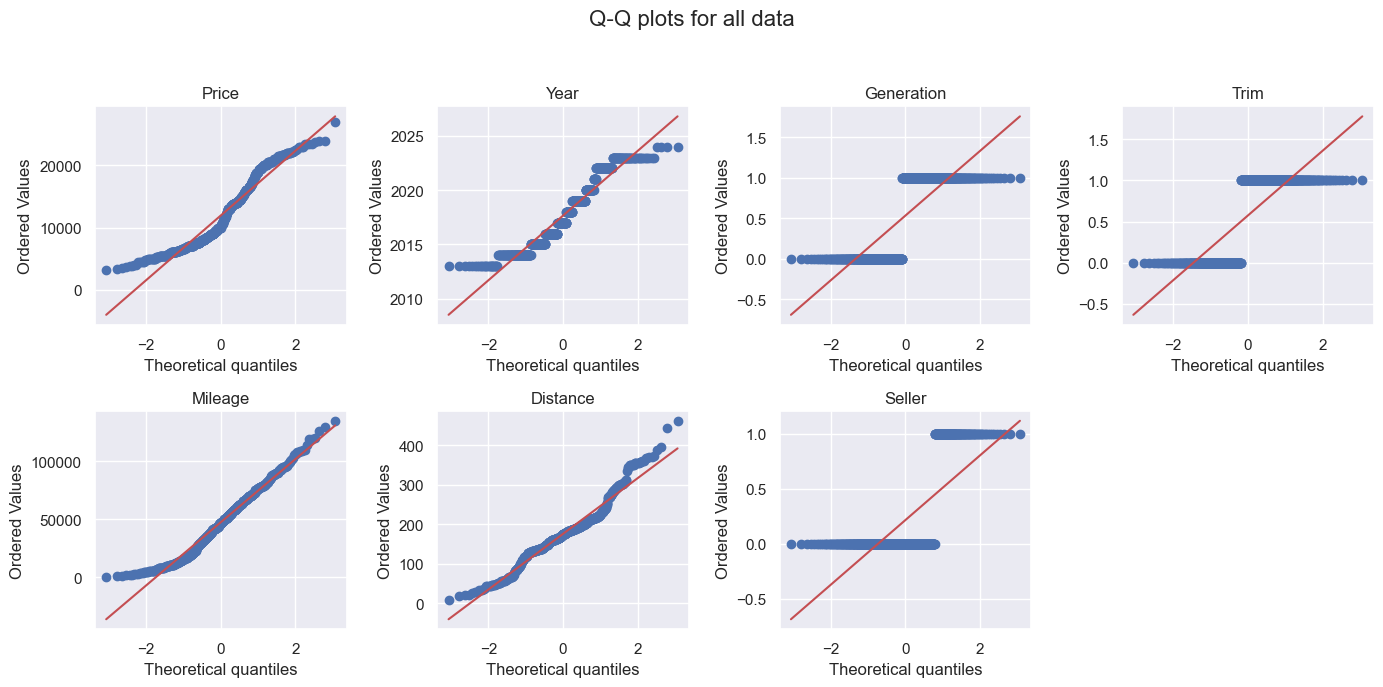

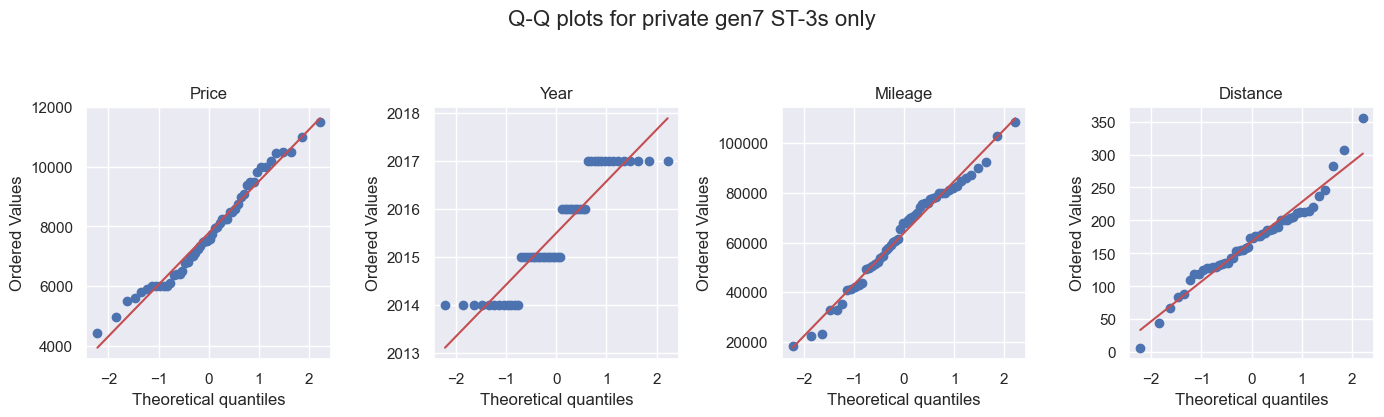

In [65]:
qq_all_columns(data, 'all data')
# qq_all_columns(gen7_data, 'gen7s only')
qq_all_columns(gen7_st3_private_data_dropped, 'private gen7 ST-3s only')

## Normality statistics

In [16]:
display(normality_all_columns(data))
display(normality_all_columns(gen7_data))
display(normality_all_columns(gen7_st3_private_data_dropped))

,Feature,Shapiro statistic,Shapiro p-value,KS statistic,KS p-value,Skew,Kurtosis
0,Price,0.930,0.0,0.139,0.000,0.530,-0.902
1,Year,0.925,0.0,0.143,0.000,0.354,-1.086
2,Generation,0.635,0.0,0.359,0.000,-0.142,-1.980
3,Trim,0.629,0.0,0.379,0.000,-0.296,-1.912
4,Mileage,0.973,0.0,0.062,0.015,0.404,-0.168
5,Distance,0.961,0.0,0.104,0.000,0.578,1.076
6,Seller,0.508,0.0,0.483,0.000,1.371,-0.121


C:\Users\jgibb\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\jgibb\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2110: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\jgibb\AppData\Local\Temp\ipykernel_10728\538081384.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(data[column])
C:\Users\jgibb\AppData\Local\Temp\ipykernel_10728\538081384.py:127: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(data[column])


,Feature,Shapiro statistic,Shapiro p-value,KS statistic,KS p-value,Skew,Kurtosis
0,Price,0.995,0.332,0.056,0.224,0.160,-0.169
1,Year,0.900,0.000,0.189,0.000,0.060,-1.102
2,Generation,1.000,1.000,NaN,NaN,NaN,NaN
3,Trim,0.634,0.000,0.362,0.000,0.165,-1.973
4,Mileage,0.985,0.001,0.037,0.726,0.518,0.896
5,Distance,0.951,0.000,0.112,0.000,0.716,1.496
6,Seller,0.581,0.000,0.439,0.000,0.828,-1.315


,Feature,Shapiro statistic,Shapiro p-value,KS statistic,KS p-value,Skew,Kurtosis
0,Price,0.984,0.689,0.066,0.962,0.015,-0.384
1,Year,0.850,0.000,0.208,0.017,0.110,-1.370
2,Mileage,0.929,0.004,0.096,0.674,0.959,3.428
3,Distance,0.965,0.120,0.097,0.659,0.331,1.552


## Correlations

,Price,Year,Generation,Trim,Mileage,Distance,Seller
Price,1.000000,0.947516,-0.859143,0.417550,-0.883076,0.030581,-0.315495
Year,0.947516,1.000000,-0.868586,0.394909,-0.792960,0.010651,-0.273521
Generation,-0.859143,-0.868586,1.000000,-0.248320,0.689172,-0.010654,0.238182
Trim,0.417550,0.394909,-0.248320,1.000000,-0.294316,0.039174,-0.070295
Mileage,-0.883076,-0.792960,0.689172,-0.294316,1.000000,-0.018781,0.277421
Distance,0.030581,0.010651,-0.010654,0.039174,-0.018781,1.000000,-0.072795
Seller,-0.315495,-0.273521,0.238182,-0.070295,0.277421,-0.072795,1.000000


None

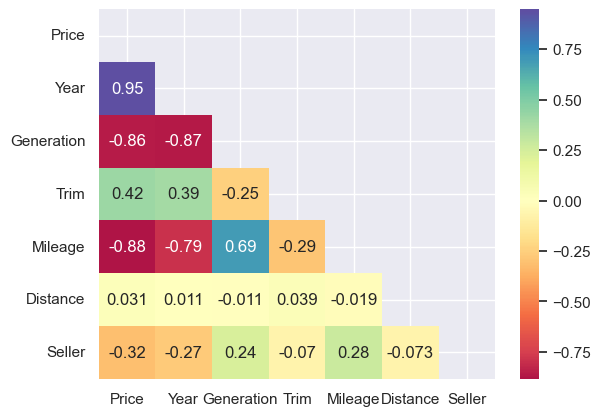

In [17]:
display(correlate(data, 'pearson'))
# display(correlate(data, 'kendall'))
# display(correlate(data, 'spearman'))
# display(correlate(gen7_st3_private_data_dropped, 'pearson'))
# display(correlate(gen7_st3_private_data_dropped, 'kendall'))
# display(correlate(gen7_st3_private_data_dropped, 'spearman'))

### Variance inflation factors

In [18]:
variables = data[['Year', 'Generation', 'Trim', 'Mileage', 'Distance', 'Seller']]
# variables = data[['Generation', 'Trim', 'Mileage', 'Distance', 'Seller']]
# variables = data[['Year', 'Trim', 'Mileage', 'Distance', 'Seller']]
# variables = gen7_data[['Year', 'Trim', 'Mileage', 'Distance', 'Seller']]
# variables = gen7_data[['Trim', 'Mileage', 'Distance', 'Seller']]
calculate_vif(variables)

,features,VIF
0,Year,12.791999
1,Generation,4.137694
2,Trim,2.582551
3,Mileage,7.910486
4,Distance,7.017019
5,Seller,1.398028


## Clustering

In [19]:
data_scaled = preprocessing.scale(data)

Text(0, 0.5, 'WCSS')

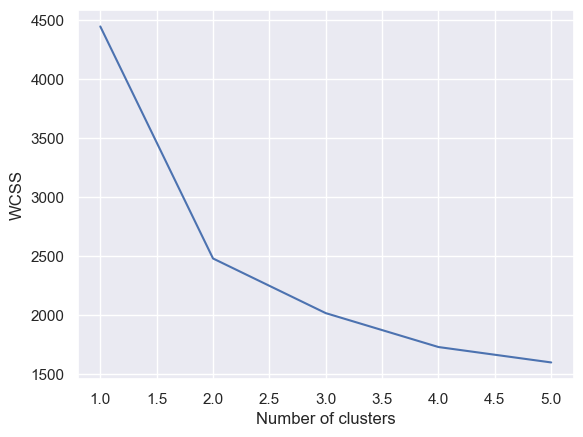

In [20]:
wcss =[]
for i in range(1,6):
    kmeans = KMeans(i)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,6),wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

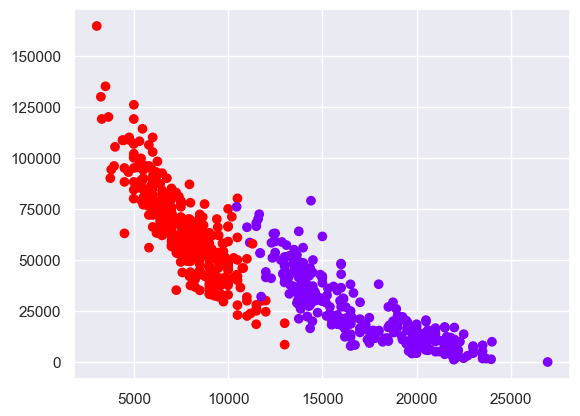

In [21]:
kmeans = KMeans(2)
clusters = kmeans.fit_predict(data_scaled)
plt.scatter(data['Price'], data['Mileage'], c=clusters, cmap='rainbow')

# Simple modelling for privately-sold generation 7 ST-3s

## Data

In [18]:
data_simple = gen7_st3_private_data_dropped.copy()
data_simple.describe()

,Price,Year,Mileage,Distance
count,52.000000,52.000000,52.000000,52.000000
mean,7782.692308,2015.500000,63853.884615,167.673077
std,1703.061851,1.128942,20482.956514,60.232791
min,4450.000000,2014.000000,18500.000000,7.000000
25%,6393.750000,2015.000000,50325.000000,132.000000
50%,7535.000000,2015.000000,67952.000000,174.000000
75%,9025.000000,2017.000000,78650.000000,200.000000
max,11490.000000,2017.000000,108518.000000,355.000000


In [19]:
X_simple = data_simple.copy()
X_simple = X_simple.drop(['Price'], axis=1)
y_simple = data_simple.copy()
y_simple = y_simple['Price']

In [ ]:
scaler = StandardScaler()
X_simple_scaled = scaler.fit_transform(X_simple)

## VIF

In [24]:
variables = data_simple[['Year', 'Mileage', 'Distance']]
calculate_vif(variables)

,features,VIF
0,Year,17.125252
1,Mileage,8.334484
2,Distance,8.879309


## OLS

In [68]:
ols(data_simple, ['Year', 'Mileage', 'Distance'], mine_simple, 'OLS for gen7 ST-3 private data')
# ols(data_simple, ['Year', 'Mileage'], 'Gen7 ST-3 private data, no distance (insignificant)')

OLS for gen7 ST-3 private data

Prediction: £9262



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     25.24
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           6.03e-10
Time:                        08:52:56   Log-Likelihood:                -435.55
No. Observations:                  52   AIC:                             879.1
Df Residuals:                      48   BIC:                             886.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.157e+05   2.82e+05     -1.828      0.074   -1.08e+06    5.14e+04
Year         261.4098    139.866      1.869      0.068     -19.811     542.630
Mileage       -0.0599      0.008     -7.802      0.000      -0.075      -0.044
Distance       2.7670      2.552      1.084      0.284      -2.365       7.899
==============================================================================
Omnibus:                       15.834   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.808
Skew:                           1.119   Prob(JB):                     5.00e-05
Kurtosis:                       5.033   Cond. No.                     1.25e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Linear regressions

In [50]:
# Unsplit

model_lr_simple_unsplit = LinearRegression()
model_lr_simple_unsplit.fit(X_simple, y_simple)

cv = 10

mae_lr_simple_cv_unsplit = cross_val_score(model_lr_simple_unsplit, X_simple, y_simple, cv=cv, scoring='neg_mean_absolute_error')
mse_lr_simple_cv_unsplit = cross_val_score(model_lr_simple_unsplit, X_simple, y_simple, cv=cv, scoring='neg_mean_squared_error')
r2_lr_simple_cv_unsplit = cross_val_score(model_lr_simple_unsplit, X_simple, y_simple, cv=cv, scoring='r2')

# Split

X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X_simple, y_simple, test_size=0.08, random_state=42)

model_lr_simple_split = LinearRegression()
model_lr_simple_split.fit(X_train_simple, y_train_simple)

model_lr_simple_split_summary = pd.DataFrame(X_simple.columns.values, columns=['Features'])

p_lr_simple_split = model_lr_simple_split.predict(X_test_simple).astype(int)

mae_lr_simple_split = mean_absolute_error(y_test_simple, p_lr_simple_split)
mse_lr_simple_split = mean_squared_error(y_test_simple, p_lr_simple_split)

mae_lr_simple_cv_split = cross_val_score(model_lr_simple_split, X_train_simple, y_train_simple, cv=cv, scoring='neg_mean_absolute_error')
mse_lr_simple_cv_split = cross_val_score(model_lr_simple_split, X_train_simple, y_train_simple, cv=cv, scoring='neg_mean_squared_error')
r2_lr_simple_cv_split = cross_val_score(model_lr_simple_split, X_train_simple, y_train_simple, cv=cv, scoring='r2')

# Results

results_lr_simple = {
    'Metric': ['MAE', 'MSE', 'CV MAE', 'CV MSE', 'CV R²', 'Prediction'],
    'Unsplit': [
        '',
        '',
        f"{int(mae_lr_simple_cv_unsplit.mean())}",
        f"{int(mse_lr_simple_cv_unsplit.mean())}",
        f"{r2_lr_simple_cv_unsplit.mean():.3f}",
        f"£{int(model_lr_simple_unsplit.predict(mine_simple)[0])}"
    ],
    'Split': [
        f"{int(mae_lr_simple_split)}",
        f"{int(mse_lr_simple_split)}",
        f"{int(mae_lr_simple_cv_split.mean())}",
        f"{int(mse_lr_simple_cv_split.mean())}",
        f"{r2_lr_simple_cv_split.mean():.3f}",
        f"£{int(model_lr_simple_split.predict(mine_simple)[0])}"
    ]
}
results_lr_simple_df = pd.DataFrame(results_lr_simple)

model_lr_simple_summary = pd.DataFrame(X_simple.columns.values, columns=['Features'])
model_lr_simple_summary['Weights (unsplit)'] = model_lr_simple_unsplit.coef_
model_lr_simple_summary['Weights (split)'] = model_lr_simple_split.coef_

# Can only show one prettily

display(results_lr_simple_df)
print()
display(model_lr_simple_summary)

,Metric,Unsplit,Split
0,MAE,,1192
1,MSE,,2507562
2,CV MAE,-871,-867
3,CV MSE,-1312737,-1251803
4,CV R²,0.277,-0.062
5,Prediction,£9262,£9213


,Features,Weights (unsplit),Weights (split)
0,Year,261.409791,238.836566
1,Mileage,-0.059914,-0.062248
2,Distance,2.766963,2.707237


## Lasso, Ridge, Elastic Net

In [45]:
lasso_model = Lasso()
ridge_model = Ridge()
en_model = ElasticNet() 

la_scores = cross_val_score(lasso_model, X_simple_scaled, y_simple, cv=3, scoring='neg_mean_absolute_error')
# print(int(la_scores.mean()))
r_scores = cross_val_score(ridge_model, X_simple_scaled, y_simple, cv=3, scoring='neg_mean_absolute_error')
# print(int(r_scores.mean()))
en_scores = cross_val_score(en_model, X_simple_scaled, y_simple, cv=3, scoring='neg_mean_absolute_error')
# print(int(en_scores.mean()))

alpha_values = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]

cv = 10

param_grid = {'alpha': alpha_values}
grid_search_lasso = GridSearchCV(lasso_model, param_grid, cv=10, scoring='neg_mean_absolute_error')
grid_search_lasso.fit(X_simple_scaled, y_simple)
test_score_lasso = grid_search_lasso.best_estimator_.score(X_simple_scaled, y_simple)

param_grid = {'alpha': alpha_values}
grid_search_ridge = GridSearchCV(ridge_model, param_grid, cv=10, scoring='neg_mean_absolute_error')
grid_search_ridge.fit(X_simple_scaled, y_simple)
test_score_ridge = grid_search_ridge.best_estimator_.score(X_simple_scaled, y_simple)

l1_ratios = np.linspace(0, 1, 11)
param_grid_en = {'alpha': alpha_values, 'l1_ratio': l1_ratios}
grid_search_en = GridSearchCV(en_model, param_grid_en, cv=10, scoring='neg_mean_absolute_error')
grid_search_en.fit(X_simple_scaled, y_simple)
test_score_en = grid_search_en.best_estimator_.score(X_simple_scaled, y_simple)
print(f"Best l1 ratio value: {grid_search_en.best_params_['l1_ratio']}")

results_lre_simple = {
    'Metric': ['Alpha', 'CV MAE', 'CV R²'],
    'Lasso': [
        f"{grid_search_lasso.best_params_['alpha']}",
        f"{int(grid_search_lasso.best_score_)}",
        f"{test_score_lasso:.3f}"
    ],
    'Ridge': [
        f"{grid_search_ridge.best_params_['alpha']}",
        f"{int(grid_search_ridge.best_score_)}",
        f"{test_score_ridge:.3f}"
    ],
    'Elastic Net': [
        f"{grid_search_en.best_params_['alpha']}",
        f"{int(grid_search_en.best_score_)}",
        f"{test_score_en:.3f}"
    ]
}
results_lre_simple_df = pd.DataFrame(results_lre_simple)
display(results_lre_simple_df)


Best l1 ratio value: 1.0


,Metric,Lasso,Ridge,Elastic Net
0,Alpha,1e-07,1e-07,1e-07
1,CV MAE,-871,-871,-871
2,CV R²,0.612,0.612,0.612


## Leave-one-out cross validation (LOOCV)

In [23]:
loo = LeaveOneOut()
model_loo = LinearRegression()

predictions_loo = []
actual_prices = []

for train_index, test_index in loo.split(X_simple):
    X_train, X_test = X_simple.iloc[train_index], X_simple.iloc[test_index]
    y_train, y_test = y_simple.iloc[train_index], y_simple.iloc[test_index]
    model_loo.fit(X_train, y_train)
    y_pred = model_loo.predict(X_test)
    predictions_loo.append(y_pred[0])
    actual_prices.append(y_test.values[0])

mae_loo = mean_absolute_error(actual_prices, predictions_loo)
mse_loo = mean_squared_error(actual_prices, predictions_loo)
print(f'Mean Absolute Error: {int(mae_loo)}')
print(f'Mean Squared Error: {int(mse_loo)}')
print()

model_loo.fit(X_simple, y_simple)
print(f'Prediction: £{int(model_loo.predict(mine_simple)[0])}')

Mean Absolute Error: 934
Mean Squared Error: 1374893

Prediction: £9191


# More complex modelling for the entire dataset

In [ ]:
ols(data, mine_all, ['Year','Generation','Trim','Mileage','Distance','Seller'], 'All data, all columns')
# ols(data, mine_all,['Generation','Trim','Mileage','Distance','Seller'], 'All data, no year (high correlation)')
# ols(data, mine_all,['Generation','Trim','Mileage','Seller'], 'All data, no year (high correlation), no distance (insignificant)')

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X,y)
p_lr = model_lr.predict(mine_all).astype(int)
model_lr_summary = pd.DataFrame(X.columns.values, columns=['Features'])
model_lr_summary['Weights'] = model_lr.coef_

model_dtr = DecisionTreeRegressor()
model_dtr.fit(X,y)
p_dtr = model_dtr.predict(mine_all).astype(int)

model_rfr = RandomForestRegressor()
model_rfr.fit(X,y)
p_rfr = model_rfr.predict(mine_all).astype(int)

model_gbr = GradientBoostingRegressor(random_state=42)
model_gbr.fit(X,y)
p_gbr = model_gbr.predict(mine_all).astype(int)

model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X,y)
p_xgb = model_xgb.predict(mine_all).astype(int)

print(f'Linear:         £{p_lr[0]}')
print(f'Decision Tree:  £{p_dtr[0]}')
print(f'Random Forest:  £{p_rfr[0]}')
print(f'Gradient Boost: £{p_gbr[0]}')
print(f'XG Boost:      £{p_xgb[0]}')
print(f'Mean:           £{int(np.mean([p_lr,p_dtr,p_rfr,p_gbr,p_xgb]))}')
print()
print('Linear summary')
model_lr_summary

## Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
p_lr = model_lr.predict(X_test).astype(int)

model_dtr = DecisionTreeRegressor(random_state=42)
model_dtr.fit(X_train,y_train)
p_dtr = model_dtr.predict(X_test).astype(int)

model_rfr = RandomForestRegressor(random_state=42, n_estimators=100, criterion='absolute_error', max_depth=10, min_samples_split=5)
model_rfr.fit(X_train,y_train)
p_rfr = model_rfr.predict(X_test).astype(int)

model_gbr = GradientBoostingRegressor(random_state=42)
model_gbr.fit(X_train,y_train)
p_gbr = model_gbr.predict(X_test).astype(int)

model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train,y_train)
p_xgb = model_xgb.predict(X_test).astype(int)

mae_lr = mean_absolute_error(y_test, p_lr)
mae_dtr = mean_absolute_error(y_test, p_dtr)
mae_rfr = mean_absolute_error(y_test, p_rfr)
mae_gbr = mean_absolute_error(y_test, p_gbr)
mae_xgb = mean_absolute_error(y_test, p_xgb)

print(f'Gradient Boosting:\t{p_gbr[:5]}\t\tMAE: {int(mae_gbr)}\tPrediction: £{int(model_gbr.predict(mine_all)[0])}')
print(f'Random Forest:\t\t{p_rfr[:5]}\t\tMAE: {int(mae_rfr)}\tPrediction: £{int(model_rfr.predict(mine_all)[0])}')
print(f'XG Boost:\t\t{p_xgb[:5]}\t\tMAE: {int(mae_xgb)}\tPrediction: £{int(model_xgb.predict(mine_all)[0])}')
print(f'Decision Tree:\t\t{p_dtr[:5]}\t\tMAE: {int(mae_dtr)}\tPrediction: £{int(model_dtr.predict(mine_all)[0])}')
print(f'Linear:\t\t\t{p_lr[:5]}\t\tMAE: {int(mae_lr)}\tPrediction: £{int(model_lr.predict(mine_all)[0])}')

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

results = pd.DataFrame(columns=['Model', 'Mean Squared Error', 'R² Score'])

for name, model in models.items():
    model.fit(X_train_simple, y_train_simple)
    y_pred_simple = model.predict(X_test_simple)
    mse = mean_squared_error(y_test_simple, y_pred_simple)
    r2 = r2_score(y_test_simple, y_pred_simple)
    results = pd.concat([results, pd.DataFrame({'Model': [name], 'Mean Squared Error': [mse], 'R² Score': [r2]})], ignore_index=True)

results

# Tuning and experimenting

## Cross validation

In [ ]:
cv = 10

model_gbr = GradientBoostingRegressor(random_state=42)
scores = cross_val_score(model_gbr, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
print(f"Gradient Boost\tCV MAE: {-scores.mean():.2f}")

model_xgb = XGBRegressor(random_state=42)
scores = cross_val_score(model_xgb, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
print(f"XG Boost\tCV MAE: {-scores.mean():.2f}")

model_rfr = RandomForestRegressor()
scores = cross_val_score(model_rfr, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
print(f"Random Forest\tCV MAE: {-scores.mean():.2f}")

model_dtr = DecisionTreeRegressor()
scores = cross_val_score(model_dtr, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
print(f"Decision Tree\tCV MAE: {-scores.mean():.2f}")

model_lr = LinearRegression()
scores = cross_val_score(model_lr, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
print(f"Linear\t\tCV MAE: {-scores.mean():.2f}")

## RandomizedSearchCV

In [ ]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
}

model_xgb = XGBRegressor(random_state=42)

rs_xgb = RandomizedSearchCV(model_xgb, param_distributions=param_grid_xgb, n_iter=100, cv=3, random_state=42, scoring ='neg_mean_absolute_error')

rs_xgb.fit(X_train,y_train)

print('best stcore = ' + str(rs_xgb.best_score_))
print('best params = ' + str(rs_xgb.best_params_))

In [67]:
learning_rate_range = np.arange(0.1, 1.1, 0.1)
learning_rate_range = np.round(learning_rate_range, decimals=1)
learning_rate_range = learning_rate_range.tolist()
n_estimators_range = list(range(100,1001,50))
max_depth_range = list(range(1,11))
param_grid_gb = {
    'learning_rate': learning_rate_range,
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'criterion': ['squared_error', 'friedman_mse']
}

model_gb = GradientBoostingRegressor(random_state=42)

rs_gb = RandomizedSearchCV(model_gb, param_distributions=param_grid_gb, n_iter=100, cv=3, random_state=42, scoring ='neg_mean_absolute_error')

print('best stcore = ' + str(rs_gb.best_score_))
print('best params = ' + str(rs_gb.best_params_))

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_score_'

In [66]:
n_estimators_range = list(range(50,201,50))
max_depth_range = list(range(1,21))
min_samples_split_range = list(range(2,22))
param_grid_rf = {
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'min_samples_split': min_samples_split_range,
    'criterion': ['squared_error', 'absolute_error']
}

model_rf = RandomForestRegressor(random_state=42)

rs_rf = RandomizedSearchCV(model_rf, param_distributions=param_grid_rf, n_iter=100, cv=3, random_state=42, scoring ='neg_mean_absolute_error')

print('best stcore = ' + str(rs_rf.best_score_))
print('best params = ' + str(rs_rf.best_params_))

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_score_'

## GridSearchCVs

### Random forest

In [ ]:
n_estimators_range = list(range(50,201,50))
max_depth_range = list(range(1,21))
min_samples_split_range = list(range(2,22))
param_grid = {
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'min_samples_split': min_samples_split_range,
    'criterion': ['squared_error', 'absolute_error']
}

params = { 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 10, 'criterion': 'squared_error' }
model_rf = RandomForestRegressor(random_state=53, **params)
start_time = time.time()
for i in range(10):
    model_rf.fit(X_train, y_train)
end_time = time.time()
sample_fit_time = end_time - start_time
print(f"Time taken for 10 fits: {sample_fit_time:.4f} seconds")

cv = 5
fits = len(n_estimators_range) * len(max_depth_range) * len(min_samples_split_range) * len(param_grid['criterion'])
cvsandstats = cv * 3
print(f"Total number of fits: {fits} x {cvsandstats} = {fits*cvsandstats}")
print(f"Approximate time for all fits: {sample_fit_time/10*(fits*cvsandstats)/60:.2f} minutes")

In [ ]:
# model_rf = RandomForestRegressor(random_state=53)

# grid_search_rf_mae = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=cv, scoring='neg_mean_absolute_error', error_score='raise')
# grid_search_rf_mae.fit(X_train, y_train)
# print(f'grid_search_rf_mae complete')

# grid_search_rf_mse = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
# grid_search_rf_mse.fit(X_train, y_train)
# print(f'grid_search_rf_mse complete')

# grid_search_rf_r2 = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=cv, scoring='r2', error_score='raise')
# grid_search_rf_r2.fit(X_train, y_train)
# print(f'grid_search_rf_r2 complete')
# print()

# print(f"Best Parameters (MAE): {grid_search_rf_mae.best_params_}")
# print(f"Best Parameters (MSE): {grid_search_rf_mse.best_params_}")
# print(f"Best Parameters (R²): {grid_search_rf_r2.best_params_}")
# print()
# print(f"Best Score (MAE): {-grid_search_rf_mae.best_score_:.2f}")
# print(f"Best Score (MSE): {-grid_search_rf_mse.best_score_:.2f}")
# print(f"Best Score (R²): {grid_search_rf_r2.best_score_:.2f}")

### Gradient boosting

In [ ]:
learning_rate_range = np.arange(0.1, 1.1, 0.1)
learning_rate_range = np.round(learning_rate_range, decimals=1)
learning_rate_range = learning_rate_range.tolist()
n_estimators_range = list(range(100,1001,50))
max_depth_range = list(range(1,11))
param_grid = {
    'learning_rate': learning_rate_range,
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'criterion': ['squared_error', 'friedman_mse']
}

params = { 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'criterion': 'friedman_mse' }
model_gb = GradientBoostingRegressor(random_state=42, **params)
start_time = time.time()
for i in range(10):
    model_gb.fit(X_train, y_train)
end_time = time.time()
single_fit_time = end_time - start_time
print(f"Time taken for 10 fits: {sample_fit_time:.4f} seconds")

cv = 5
fits = len(n_estimators_range) * len(max_depth_range) * len(learning_rate_range) * len(param_grid['criterion'])
cvsandstats = cv * 3
print(f"Total number of fits: {fits} x {cvsandstats} = {fits*cvsandstats}")
print(f"Approximate time for all fits: {sample_fit_time/10*(fits*cvsandstats)/60:.2f} minutes")

In [ ]:
# model_gb = GradientBoostingRegressor(random_state=20)

# grid_search_gb_mae = GridSearchCV(estimator=model_gb, param_grid=param_grid, cv=cv, scoring='neg_mean_absolute_error', error_score='raise')
# grid_search_gb_mae.fit(X_train, y_train)
# print(f'grid_search_gb_mae complete')
# print(f"Best Parameters (MAE): {grid_search_gb_mae.best_params_}")
# print(f"Best Score (MAE): {-grid_search_gb_mae.best_score_:.2f}")

# grid_search_gb_mse = GridSearchCV(estimator=model_gb, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
# grid_search_gb_mse.fit(X_train, y_train)
# print(f'grid_search_gb_mse complete')
# print(f"Best Parameters (MSE): {grid_search_gb_mse.best_params_}")
# print(f"Best Score (MSE): {-grid_search_gb_mse.best_score_:.2f}")

# grid_search_gb_r2 = GridSearchCV(estimator=model_gb, param_grid=param_grid, cv=cv, scoring='r2', error_score='raise')
# grid_search_gb_r2.fit(X_train, y_train)
# print(f'grid_search_gb_r2 complete')
# print(f"Best Parameters (R²): {grid_search_gb_r2.best_params_}")
# print(f"Best Score (R²): {grid_search_gb_r2.best_score_:.2f}")

In [ ]:
param_grid = {
    'n_estimators': [80, 100, 120],
    'learning_rate': [0.04, 0.05, 0.06],
    'max_depth': [2, 3, 4],
    'min_child_weight': [4, 5, 6],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7],
    'gamma': [0.3, 0.4, 0.5],
    'reg_alpha': [0.4, 0.5, 0.6],
    'reg_lambda': [0.9, 1.0, 1.1],
}

model_xgb = XGBRegressor(random_state=42)

params = { 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'criterion': 'friedman_mse' }
model_xgb_timer = GradientBoostingRegressor(random_state=42, **params)
start_time = time.time()
for i in range(10):
    model_xgb_timer.fit(X_train, y_train)
end_time = time.time()
single_fit_time = end_time - start_time
print(f"Time taken for 10 fits: {sample_fit_time:.4f} seconds")

cv = 5
fits = math.prod(len(i) for i in param_grid.values())
cvsandstats = cv * 3
print(f"Total number of fits: {fits} x {cvsandstats} = {fits*cvsandstats}")
print(f"Approximate time for all fits: {sample_fit_time/10*(fits*cvsandstats)/60:.2f} minutes")

# grid_search_xgb_mae = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=cv, scoring='neg_mean_absolute_error', error_score='raise')
# grid_search_xgb_mae.fit(X_train, y_train)
# print(f'grid_search_xgb_mae complete')
# print(f"Best Parameters (MAE): {grid_search_xgb_mae.best_params_}")
# print(f"Best Score (MAE): {-grid_search_xgb_mae.best_score_:.2f}")

# grid_search_xgb_mse = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
# grid_search_xgb_mse.fit(X_train, y_train)
# print(f'grid_search_xgb_mse complete')
# print(f"Best Parameters (MSE): {grid_search_xgb_mse.best_params_}")
# print(f"Best Score (MSE): {-grid_search_xgb_mse.best_score_:.2f}")

# grid_search_xgb_r2 = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=cv, scoring='r2', error_score='raise')
# grid_search_xgb_r2.fit(X_train, y_train)
# print(f'grid_search_gb_r2 complete')
# print(f"Best Parameters (R²): {grid_search_xgb_r2.best_params_}")
# print(f"Best Score (R²): {grid_search_xgb_r2.best_score_:.2f}")

## Bayesian optimisation

In [ ]:
# cv = StratifiedKFold(n_splits = 3)

# bs_lr = BayesSearchCV(
#     dt,
#     {'criterion': Categorical(['gini','entropy']),
#             'splitter': Categorical(['best','random']),
#            'max_depth': Integer(10,50),
#            'min_samples_split': Integer(2,15),
#            'max_features': Categorical(['auto','sqrt','log2',None])},
#     random_state=42,
#     n_iter= 100,
#     cv= cv,
#     scoring ='f1')

# bs_lr.fit(X_train,y_train.values.ravel())

# print('best stcore = ' + str(bs_lr.best_score_))
# print('best params = ' + str(bs_lr.best_params_))

## Linear vs random forest vs gradient boosting

In [ ]:
# params_rf = {
#     'min_samples_split': grid_search_rf_mae.best_params_['min_samples_split'],
#     'n_estimators': grid_search_rf_mae.best_params_['n_estimators'],
#     'max_depth': grid_search_rf_mae.best_params_['max_depth'],
#     'criterion': grid_search_rf_mae.best_params_['criterion']
# }
params_rf = {
    'min_samples_split': 5,
    'n_estimators': 200,
    'max_depth': 10,
    'criterion': 'absolute_error'
}

# params_gb = {
#     'learning_rate': grid_search_gb_mae.best_params_['learning_rate'],
#     'n_estimators': grid_search_gb_mae.best_params_['n_estimators'],
#     'max_depth': grid_search_gb_mae.best_params_['max_depth'],
#     'criterion': grid_search_gb_mae.best_params_['criterion'],
# }
params_gb = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 3,
    'criterion': 'squared_error',
}

model_lr = LinearRegression()
model_rf = RandomForestRegressor(random_state=42, **params_rf)
model_gb = GradientBoostingRegressor(random_state=42, **params_gb)

scoring = make_scorer(mean_absolute_error)

In [ ]:
mae_mse_r2_cv_results = []

def mae_mse_r2_cv(model):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring=scoring)
    mean_mae = cv_scores.mean()
    std_mae = cv_scores.std()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae_mse_r2_cv_results.append({'Mean MAE':mean_mae, 'Std MAE':std_mae, 'MSE':mse, 'R²':r2})

mae_mse_r2_cv(model_lr)
mae_mse_r2_cv(model_rf)
mae_mse_r2_cv(model_gb)

mae_mse_r2_cv_results_df = pd.DataFrame(mae_mse_r2_cv_results)
mae_mse_r2_cv_results_df

## Paired t-tests

In [ ]:
# t_stat, p_value = ttest_rel(cv_scores_lr, cv_scores_gb)

# print(f"Paired t-test (lr, gb) - t-statistic:\t{t_stat:.2f}")
# print(f"Paired t-test (lr, gb) - p-value:\t{p_value:.2f}")

# Conclusion

In [ ]:
int(model_gb.predict(mine_all)[0])

In [ ]:
model_xgb.fit(X_train, y_train)
int(model_xgb.predict(mine_all)[0])

In [52]:
lasso_model.fit(X_train_simple, y_train_simple)
best = int(lasso_model.predict(mine_simple)[0])
best

9212

In [65]:
st3_data_sorted = st3_data_dropped.sort_values(by='Price').reset_index()
d = 0.02
st3_data_sorted[(st3_data_sorted['Price'] > best*(1-d)) & (st3_data_sorted['Price'] < best*(1+d))]

,index,Price,Year,Generation,Mileage,Distance,Seller
106,81,9100,2017,1,33000,134,1
107,129,9150,2017,1,62000,159,0
108,210,9300,2015,1,32379,185,0
